In [23]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import geopy.distance
import matplotlib.patches as mpatches
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm

# Data
houses = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")

In [3]:
# Check the data
houses.info()
houses.isna().sum() # No NA/null values
houses.head()

# Data wrangling ideas

# Transform date column into year/month/day format
# Consider adding sqft_living, sqft_lot, sqft_above, sqft_basement for total sqft
# Indicate if a house has a basement or not
# id and zip code can be treated as keys

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


Text(-121.7, 47.3, 'King County Home Prices\n2014 - 2015')

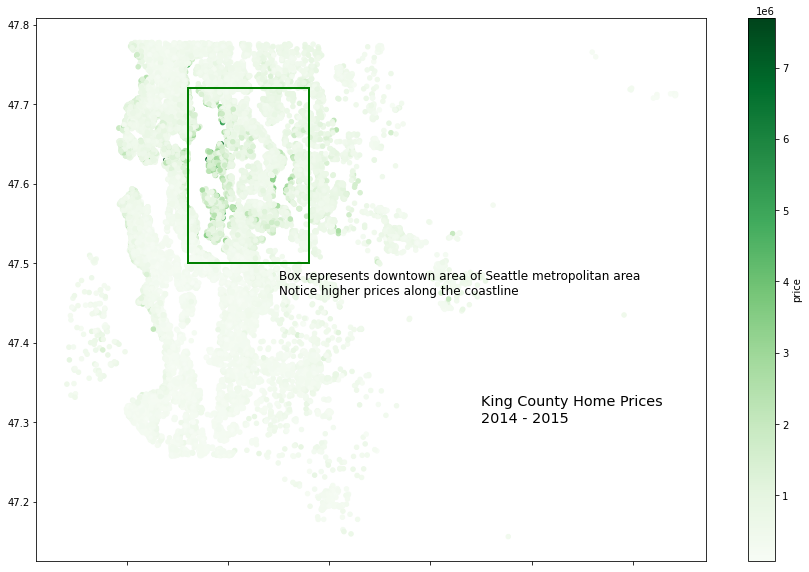

In [90]:
houses.plot(x = 'long', y = 'lat', kind = 'scatter', c = 'price', colormap = 'Greens', ylabel = '', figsize = (15, 10))
rect = mpatches.Rectangle((-122.28, 47.5), 0.24, 0.22, 
                        fill = False,
                        edgecolor = "green",
                        facecolor = 'none',
                        linewidth = 2)
	
plt.gca().add_patch(rect)

plt.text(-122.1, 47.46, 'Box represents downtown area of Seattle metropolitan area\nNotice higher prices along the coastline', fontsize = 'large')
plt.text(-121.7, 47.3, 'King County Home Prices\n2014 - 2015', fontsize = 'x-large')

In [189]:
houses['zipcode'] = houses['zipcode'].astype('category')

houses['date'] = houses['date'].astype('str').str[0:8] # Remove T000000 from the date

houses['date'] = pd.to_datetime(houses['date'], format = '%Y%m%d') # Put it into datetime column with yyyy-mm-dd format
houses['year_of_sale'] = pd.DatetimeIndex(houses['date']).year # Extract year of sale into separate column

In [190]:
houses['basement'] = houses['sqft_basement'].apply(lambda p: 0 if p == 0 else 1) # Creates column indicating if home has basement or not

houses['view'] = houses['view'].map({0 : 'Very Poor', 1 : 'Poor', 2: 'Average', 3 : 'Good', 4 : 'Very Good'}) # Replace numerical representation in view column
houses['condition'] = houses['condition'].map({1 : 'Very Poor', 2 : 'Poor', 3 : 'Average', 4 : 'Good', 5 : 'Very Good'}) # Replace numerical representation in condition column
houses['grade'] = pd.cut(x = houses['grade'], bins = [1, 3, 6, 7, 10, 13], labels = ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], include_lowest = True) # Replace numerical representation in grade column with bins

houses['age_of_home_years'] = houses['year_of_sale'] - houses['yr_built'] # Determine age of home from year of construction to year of sale
houses['years_since_renovation'] = houses['year_of_sale'] - houses['yr_renovated'] # Determine age of home since most recent renovation
houses['years_since_renovation'] = np.where(houses['years_since_renovation'] > 1000, 0, houses['years_since_renovation']) # Get rid of years that didn't get subtracted since 0 means never renovated in yr_renovated

distance_lat1 = 47.6258 # First richest area in King County latitude
distance_long1 = -122.2422 # First richest area in King County longitude
 
distance_lat2 = 47.5707 # Second richest area in King County latitude
distance_long2 = -122.2221 # Second richest area in King County longitude
 
def distancer1(row):
 coords_1 = (distance_lat1, distance_long1)
 coords_2 = (row['lat'], row['long'])
 return geopy.distance.distance(coords_1, coords_2).miles
 
def distancer2(row):
 coords_1 = (distance_lat2, distance_long2)
 coords_2 = (row['lat'], row['long'])
 return geopy.distance.distance(coords_1, coords_2).miles

houses["distance1"] = houses.apply(distancer1, axis = 1) # Apply first function to dataset
houses["distance2"] = houses.apply(distancer2, axis = 1) # Apply second function to dataset

In [191]:
houses['bedrooms'].value_counts() # One property has 33 bedrooms, change it to 3
houses['bedrooms'] = houses['bedrooms'].replace(33, 3)

In [192]:
houses[['zipcode', 'price']].groupby('zipcode').median().reset_index().sort_values(by = 'price', ascending = False) # Median price by zip code

# Top 10 expensive zip codes:
# 98039, 98004, 98040, 98112, 98006, 98005, 98075, 98119, 98109, 98102

# Top 10 cheapest zip codes
# 98022, 98148, 98023, 98003, 98198, 98188, 98001, 98032, 98002, 98168

,zipcode,price
24,98039,1892500.0
3,98004,1162500.0
25,98040,997000.0
48,98112,906000.0
5,98006,770000.0
...,...,...
67,98188,264000.0
0,98001,260000.0
20,98032,250000.0
1,98002,235000.0


In [193]:
# Test correlation
houses.corr()['price'].sort_values()

distance1                -0.392933
distance2                -0.321618
age_of_home_years        -0.054071
id                       -0.016081
year_of_sale              0.007080
long                      0.023976
yr_built                  0.054187
years_since_renovation    0.065341
sqft_lot15                0.082413
sqft_lot                  0.090317
yr_renovated              0.121534
basement                  0.180936
floors                    0.254428
waterfront                0.260133
lat                       0.307516
bedrooms                  0.314900
sqft_basement             0.325183
bathrooms                 0.527989
sqft_living15             0.585374
sqft_above                0.607082
sqft_living               0.703920
price                     1.000000
Name: price, dtype: float64

In [194]:
X = houses.drop(['price', 'date', 'lat', 'long'], axis = 1)
X = pd.get_dummies(X, drop_first = True)
y = houses['price']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [195]:
model = XGBRegressor(learning_rate = 0.2, max_depth = 5, subsample = 0.9)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

[20:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [196]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions), 2)) 
print("Mean squared error =", round(math.sqrt(sm.mean_squared_error(y_test, predictions)), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y_test, predictions), 6))

Mean absolute error = 76662.4
Mean squared error = 133132.86
Median absolute error = 47342.55
Explain variance score = 0.86
R2 score = 0.863774


In [197]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

In [198]:
holdout['zipcode'] = holdout['zipcode'].astype('category')

holdout['date'] = holdout['date'].astype('str').str[0:8] # Remove T000000 from the date

holdout['date'] = pd.to_datetime(holdout['date'], format = '%Y%m%d') # Put it into datetime column with yyyy-mm-dd format
holdout['year_of_sale'] = pd.DatetimeIndex(holdout['date']).year # Extract year of sale into separate column

holdout['basement'] = holdout['sqft_basement'].apply(lambda p: 0 if p == 0 else 1) # Creates column indicating if home has basement or not

holdout['view'] = holdout['view'].map({0 : 'Very Poor', 1 : 'Poor', 2: 'Average', 3 : 'Good', 4 : 'Very Good'}) # Replace numerical representation in view column
holdout['condition'] = holdout['condition'].map({1 : 'Very Poor', 2 : 'Poor', 3 : 'Average', 4 : 'Good', 5 : 'Very Good'}) # Replace numerical representation in condition column
holdout['grade'] = pd.cut(x = holdout['grade'], bins = [1, 3, 6, 7, 10, 13], labels = ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], include_lowest = True) # Replace numerical representation in grade column with bins

holdout['age_of_home_years'] = holdout['year_of_sale'] - holdout['yr_built'] # Determine age of home from year of construction to year of sale
holdout['years_since_renovation'] = holdout['year_of_sale'] - holdout['yr_renovated'] # Determine age of home since most recent renovation
holdout['years_since_renovation'] = np.where(holdout['years_since_renovation'] > 1000, 0, holdout['years_since_renovation']) # Get rid of years that didn't get subtracted since 0 means never renovated in yr_renovated

holdout["distance1"] = holdout.apply(distancer1, axis = 1) # Apply first function to dataset
holdout["distance2"] = holdout.apply(distancer2, axis = 1) # Apply second function to dataset

holdout = holdout.drop(['date', 'lat', 'long'], axis = 1)
holdout = pd.get_dummies(holdout, drop_first = True)

In [199]:
X_train, holdout = X_train .align(holdout, join = 'left', axis = 1, fill_value = 0)

In [200]:
holdoutPredict = model.predict(holdout)

pd.DataFrame(holdoutPredict).to_csv('devin-predictions.csv', index = False)